In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import f_classif
import joblib

In [106]:
sns.set_theme(
    style="whitegrid",
    context="notebook")

sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['figure.autolayout'] = True

In [107]:
df = pd.read_csv("Telco.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [108]:
# Check for missing values
df.isna().sum().sum()

np.int64(0)

In [109]:
# Check for duplicated values
df.customerID.duplicated().sum()

np.int64(0)

In [110]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [112]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # data type casting
df.dropna(subset=['TotalCharges'], inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

In [113]:
# Summary statistics of categorical columns
df.describe(include = 'object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,7032,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3549,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,5163


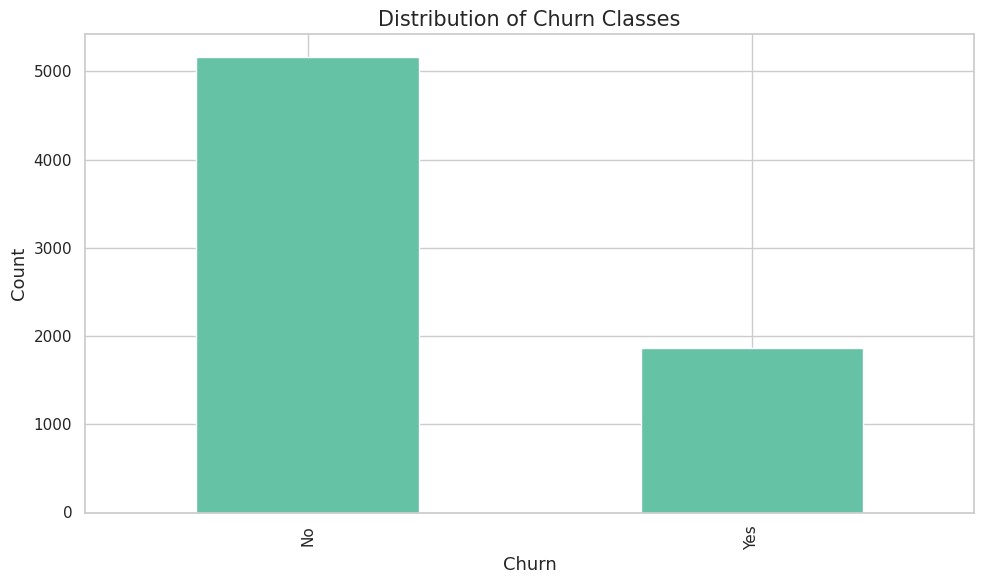

In [114]:
df['Churn'].value_counts().plot(
    kind='bar',
    title='Distribution of Churn Classes'
)

plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

In [115]:
# Summary statistics of numerical columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [116]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# Analysis of Qualitative Features



In [117]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.append('SeniorCitizen')

if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')

print("Identified categorical columns:")
print(categorical_cols)

Identified categorical columns:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


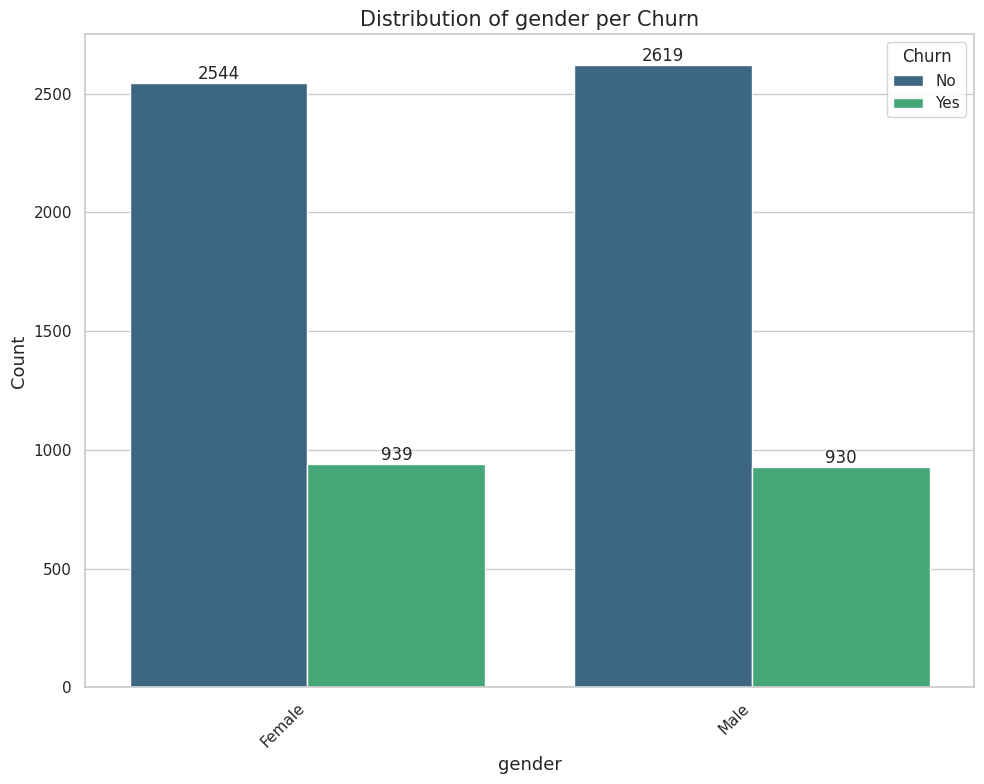

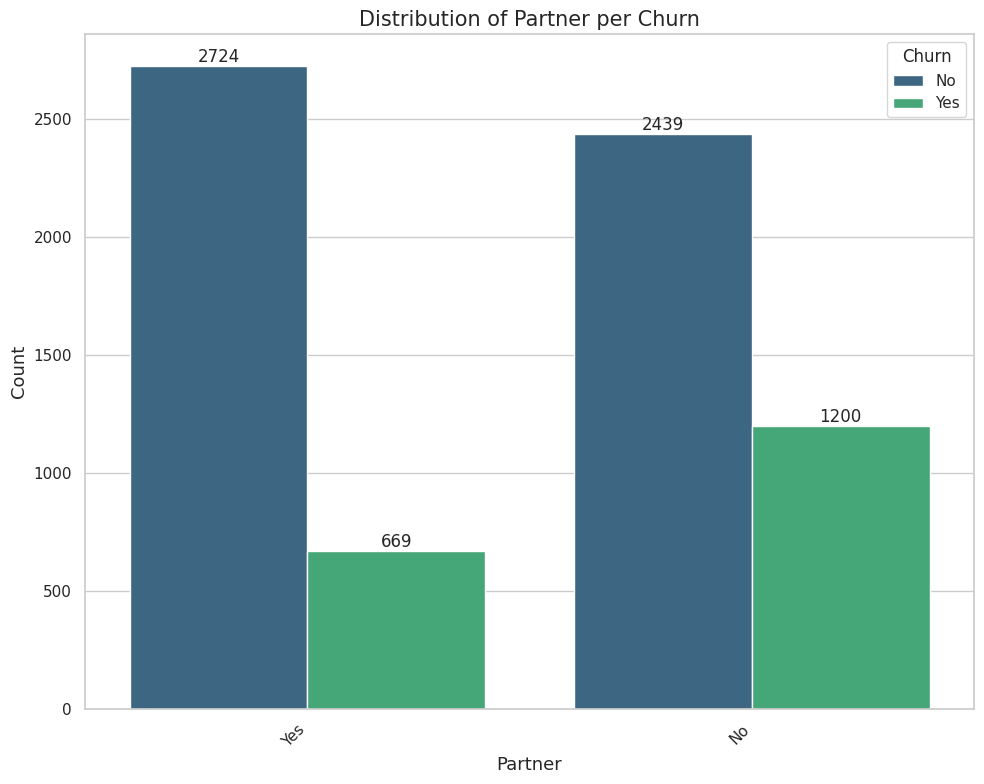

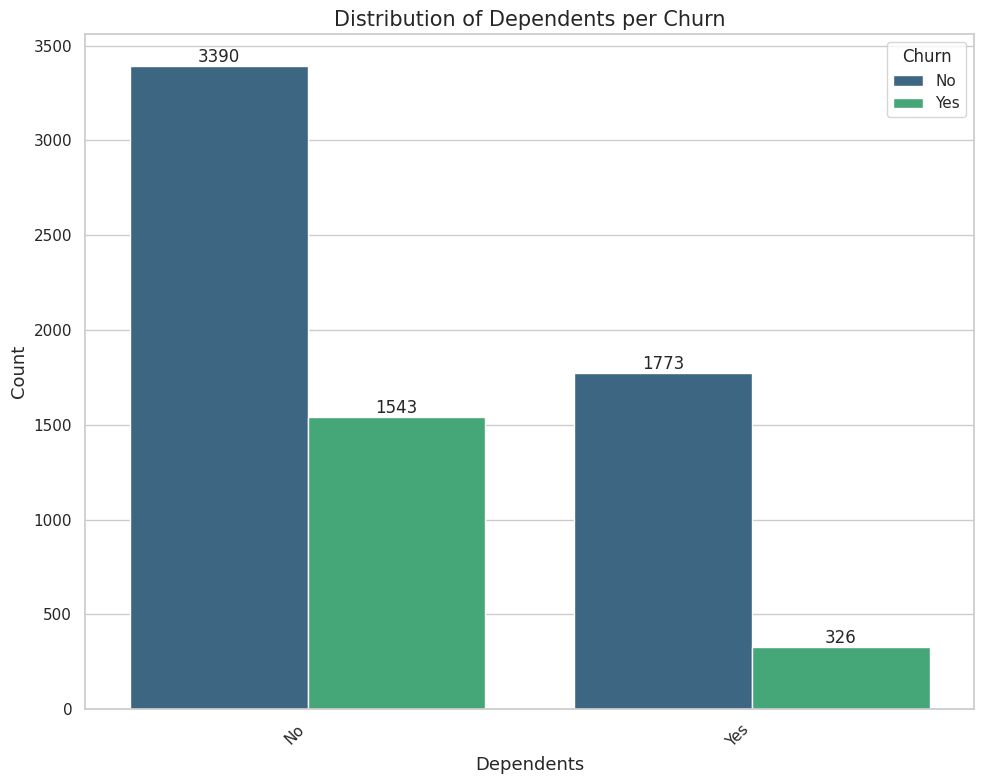

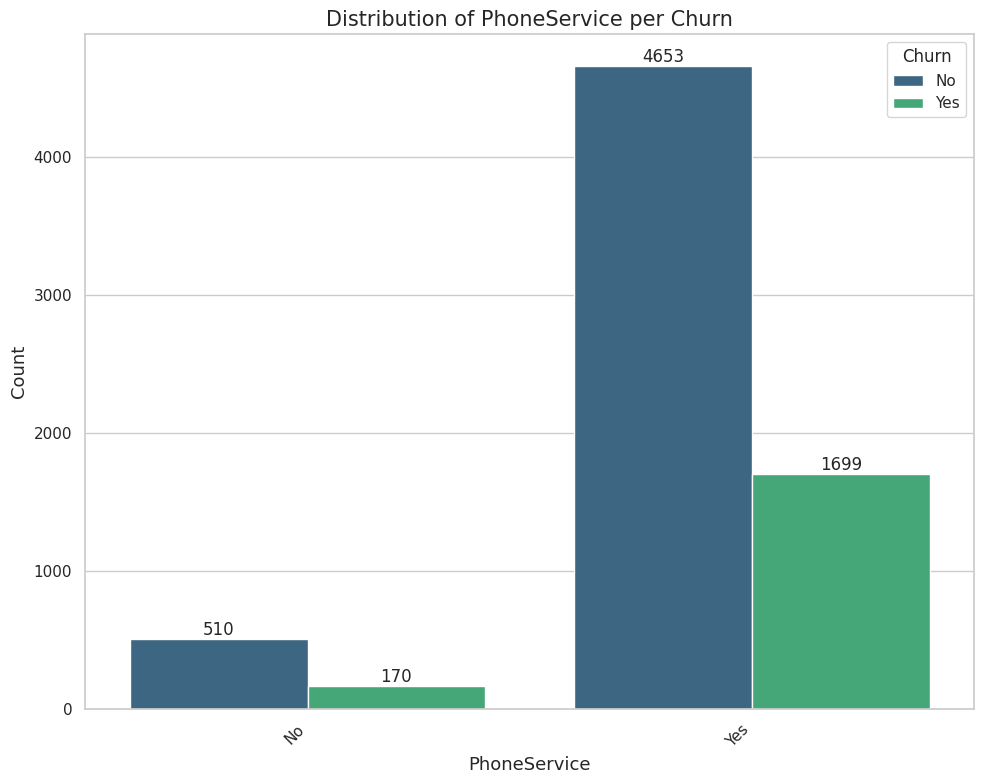

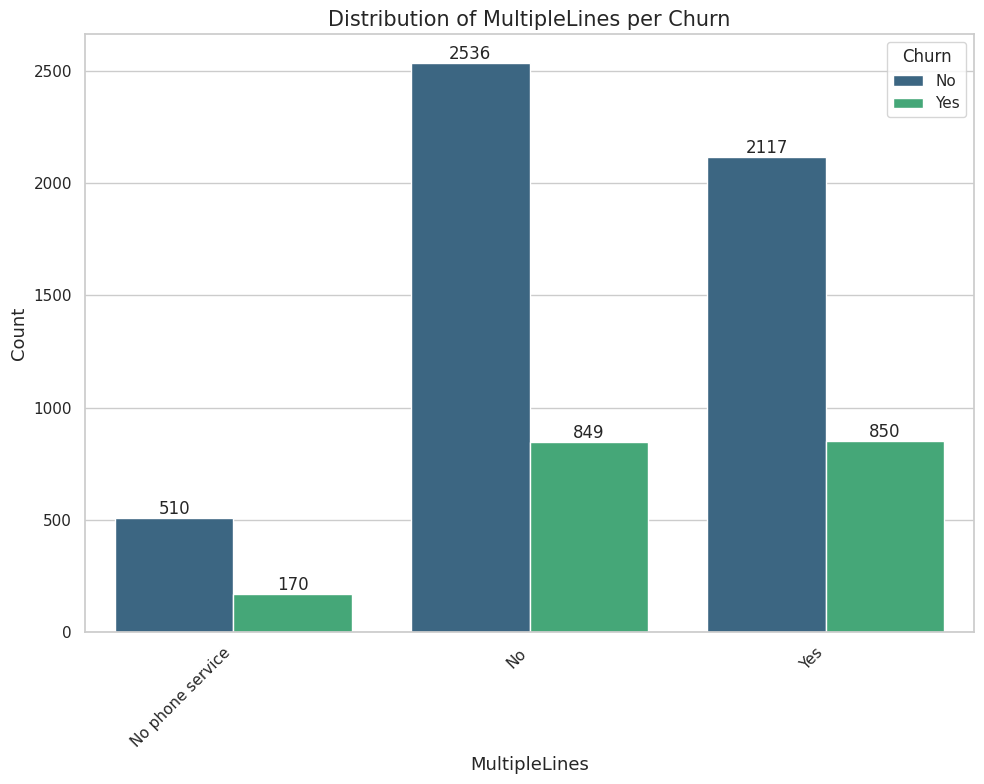

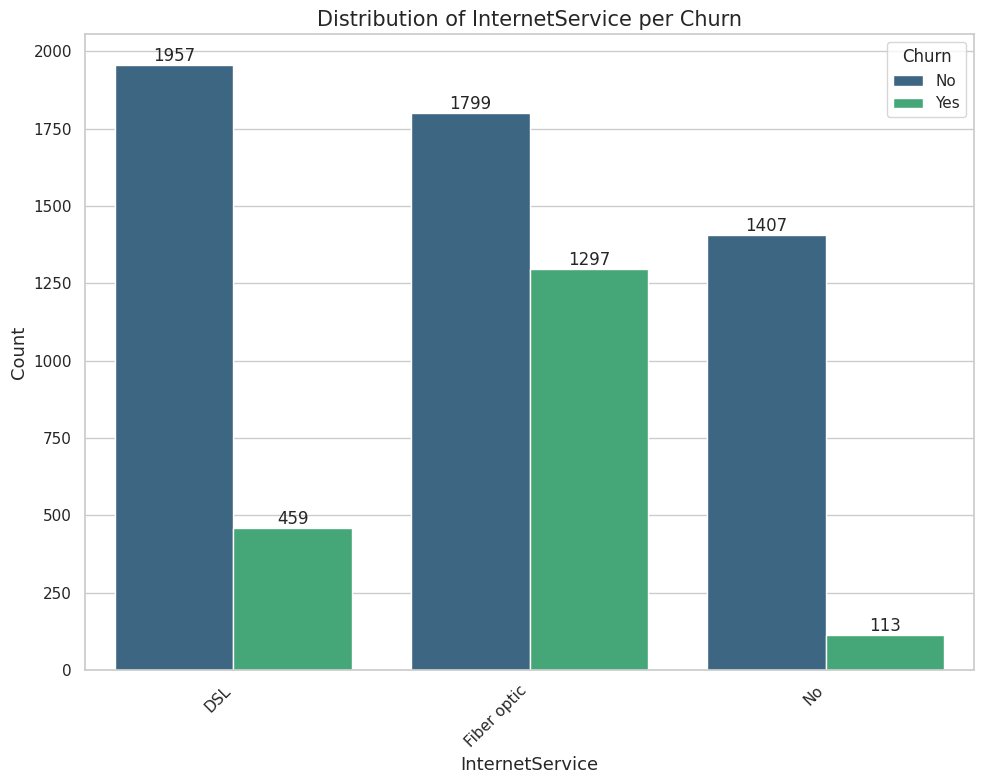

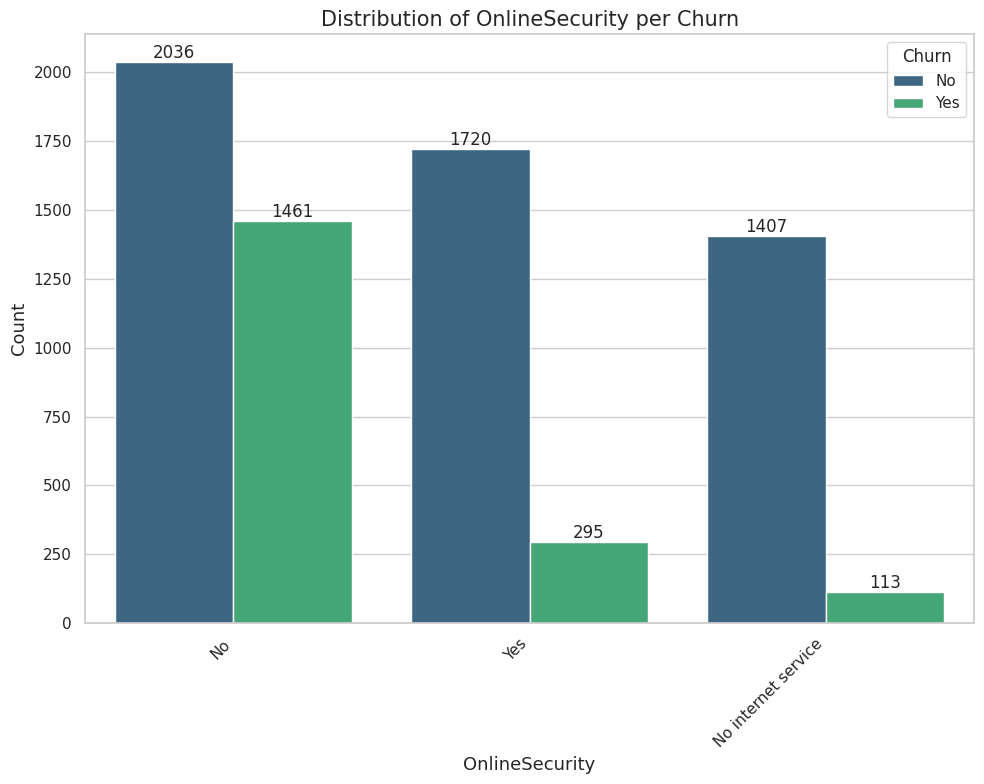

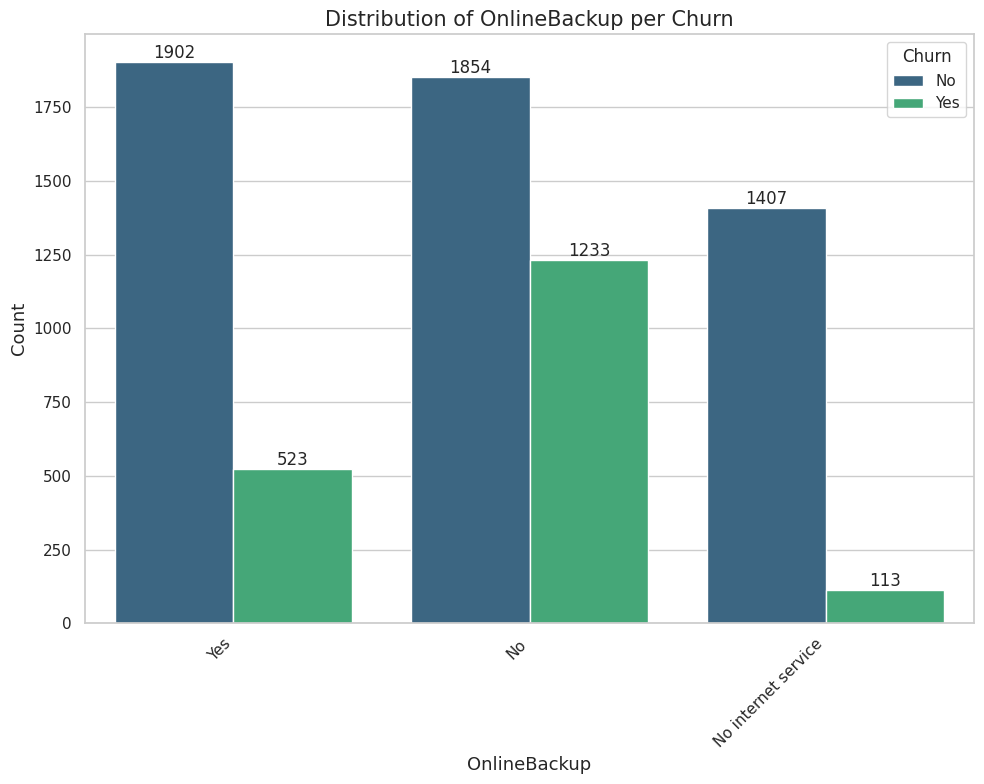

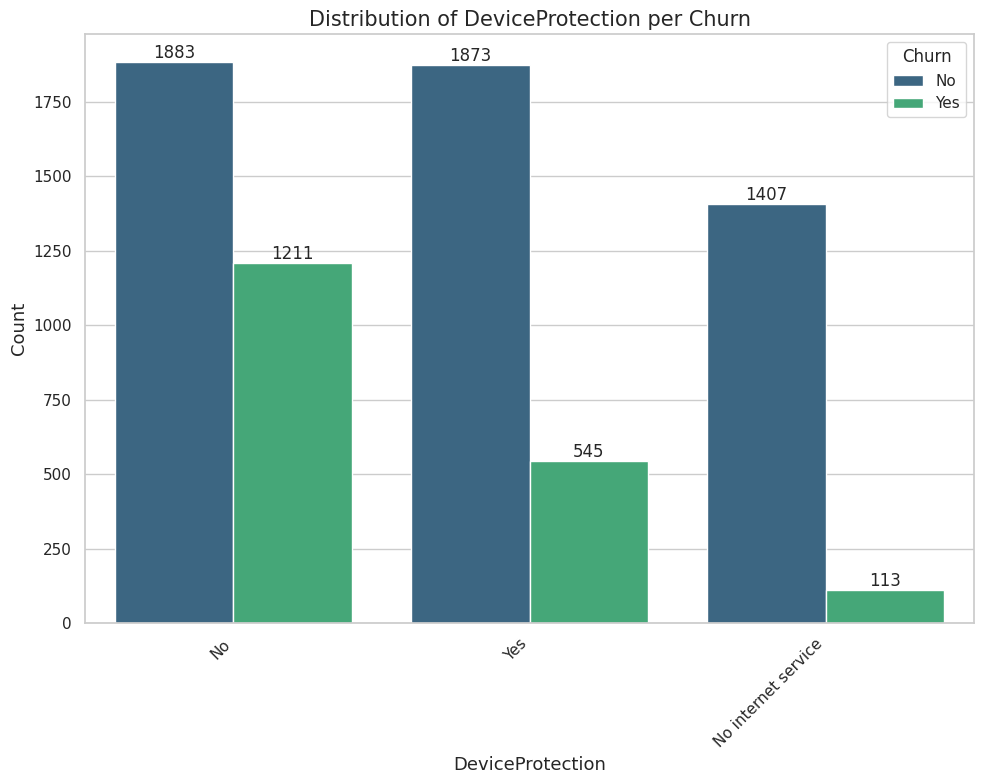

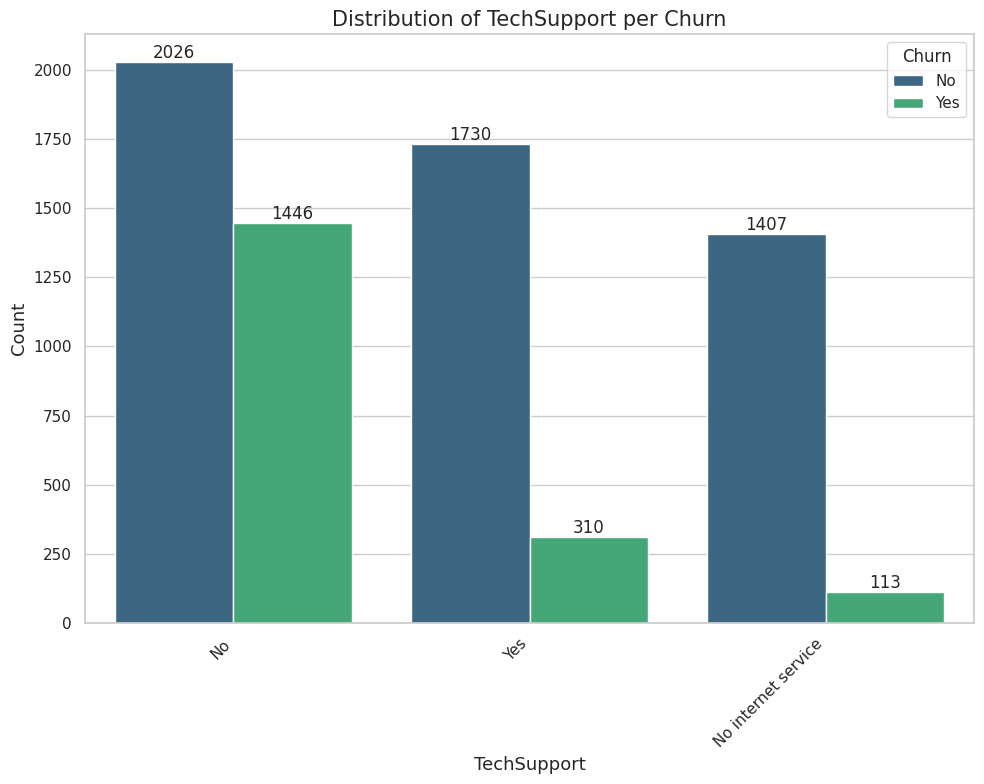

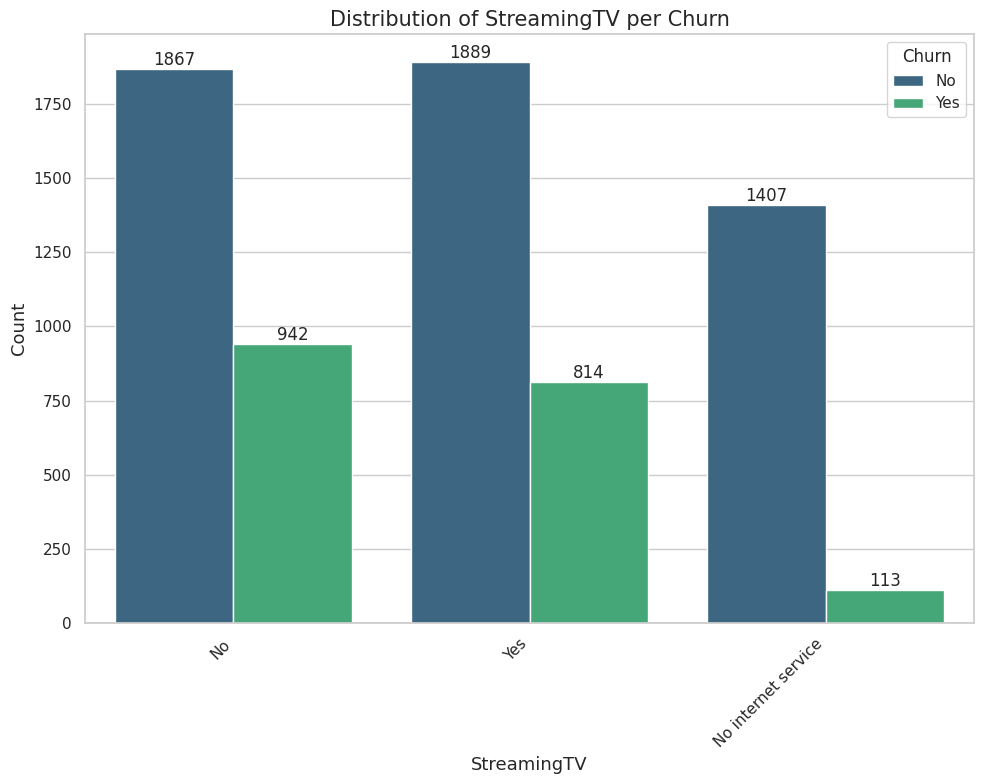

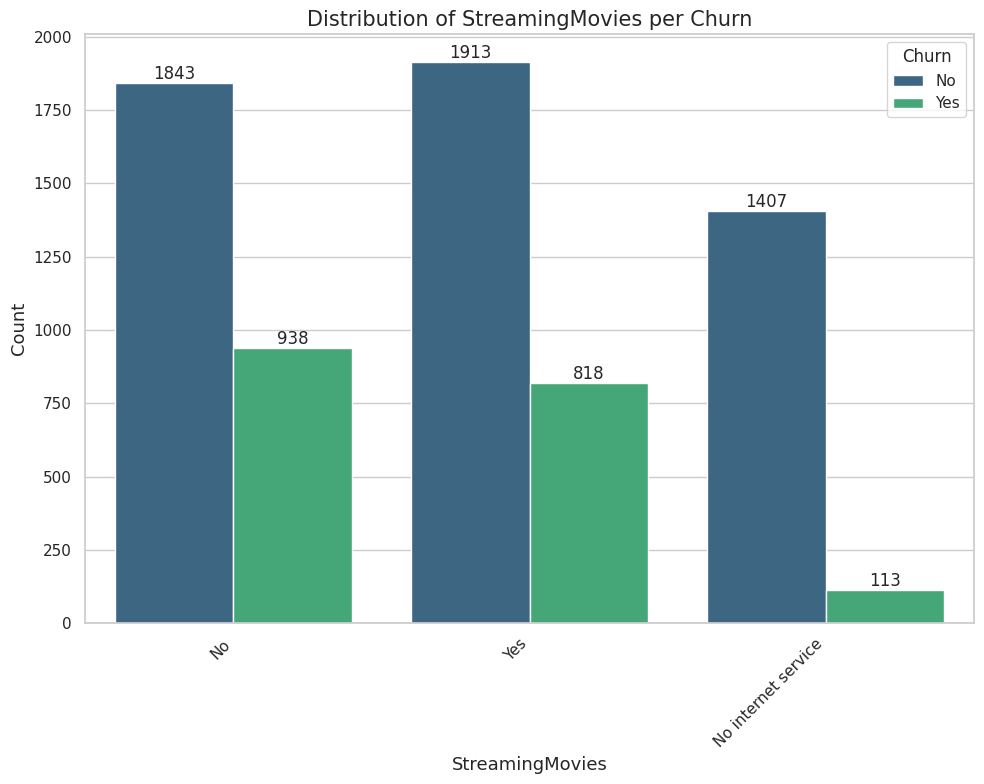

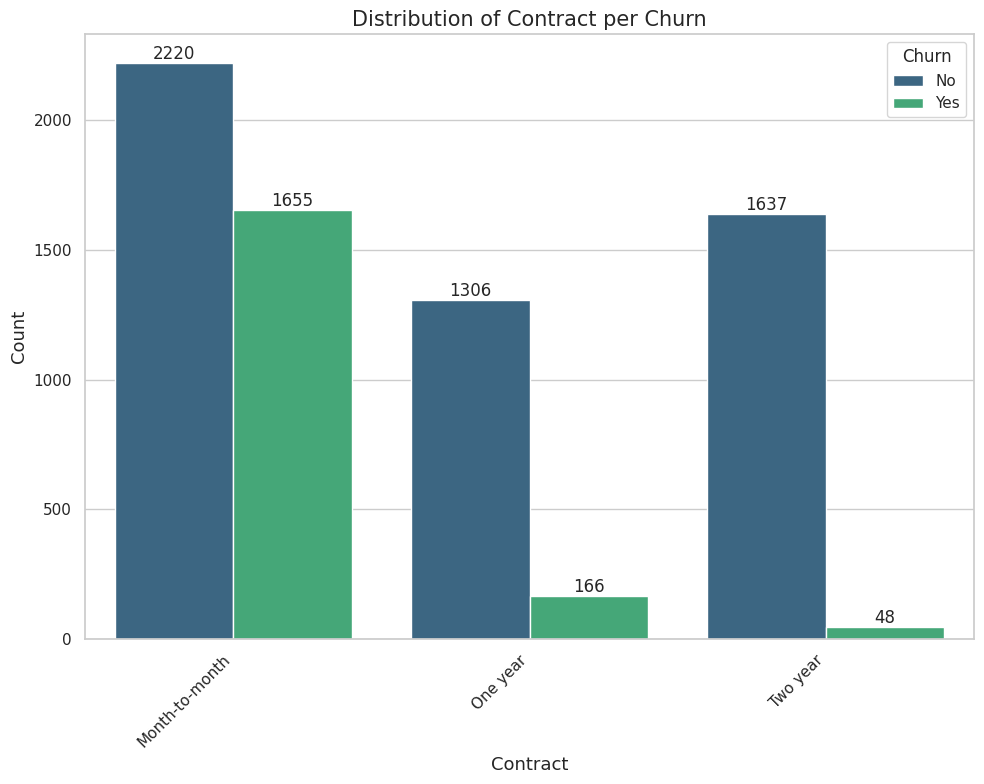

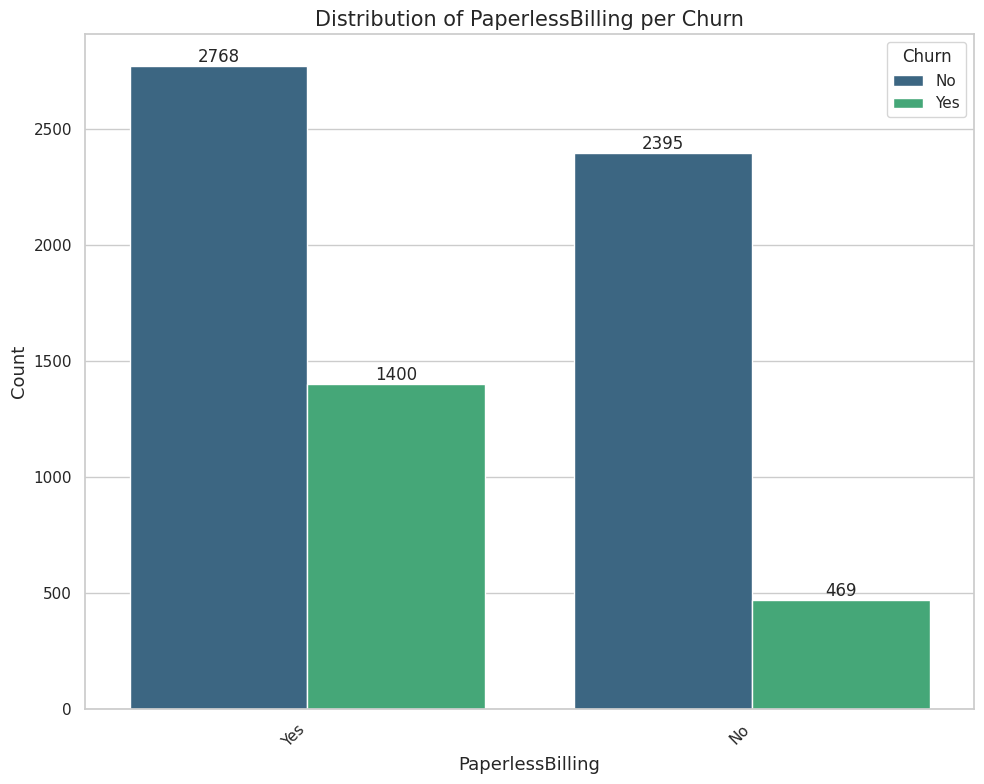

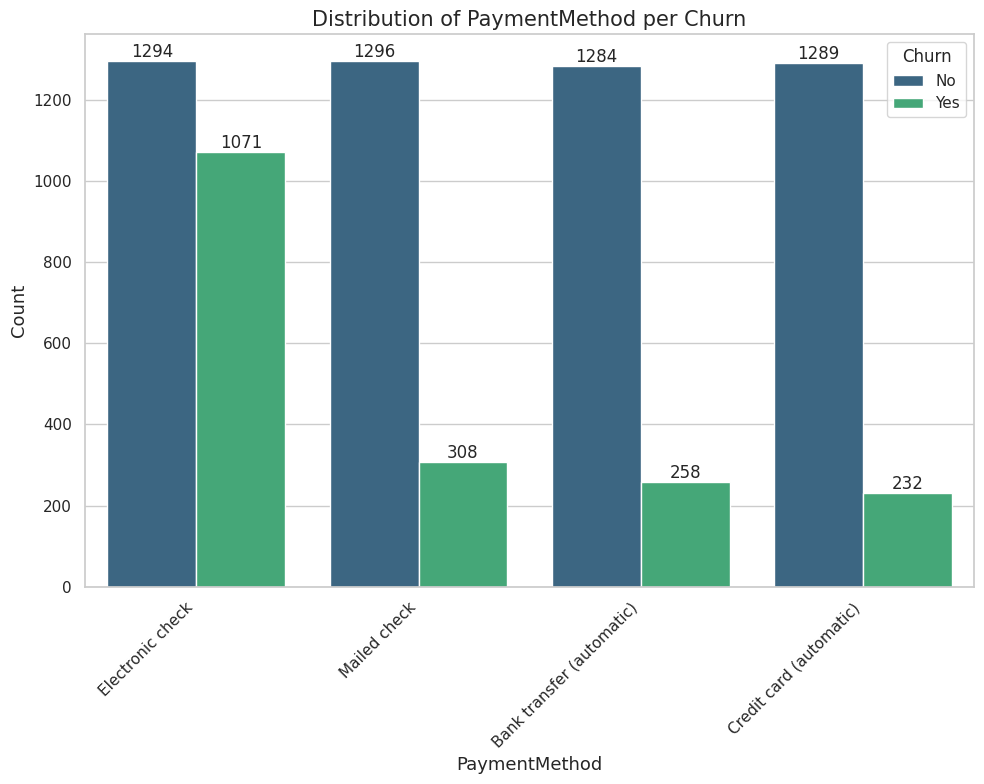

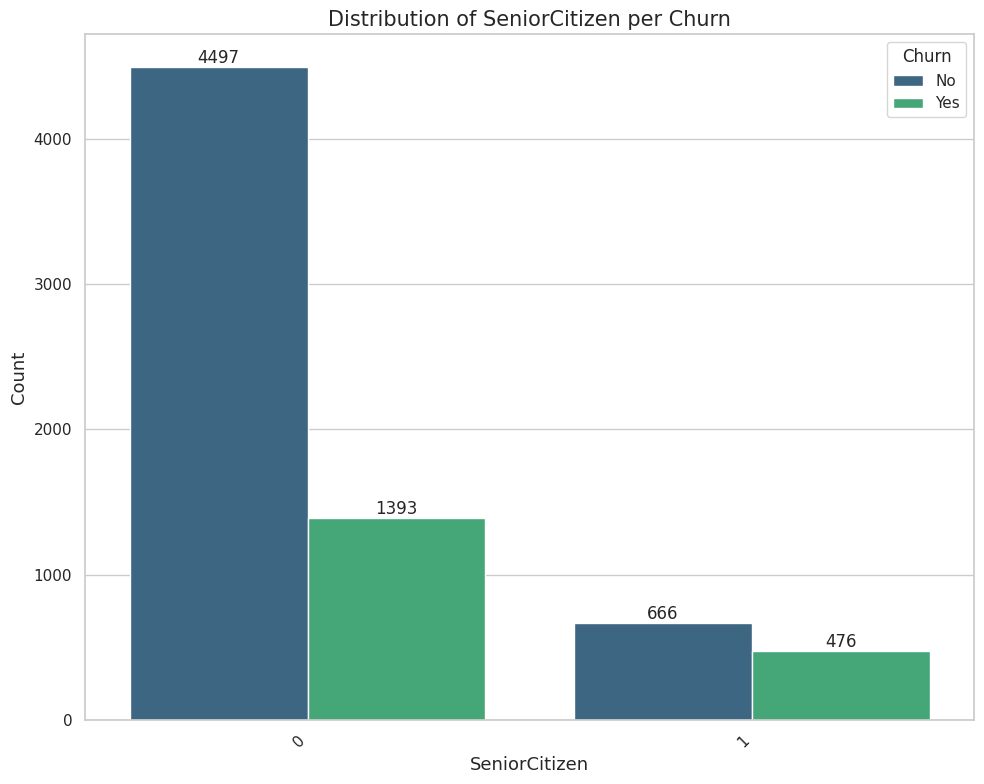

In [154]:
for col in categorical_cols:
    plt.figure(figsize=(10, 8))
    ax = sns.countplot(data=df, x=col, hue = 'Churn', palette = "viridis")

    # Count values on top of each bar
    for container in ax.containers:
        ax.bar_label(container)

    plt.title(f'Distribution of {col} per Churn')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

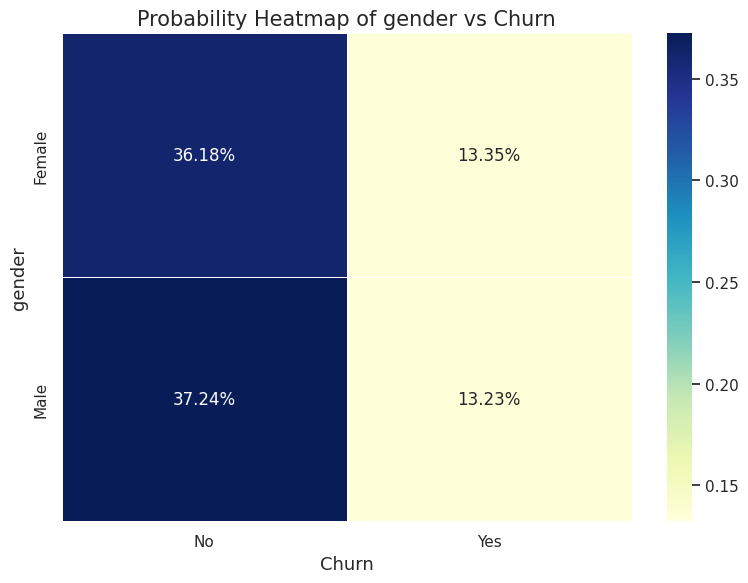

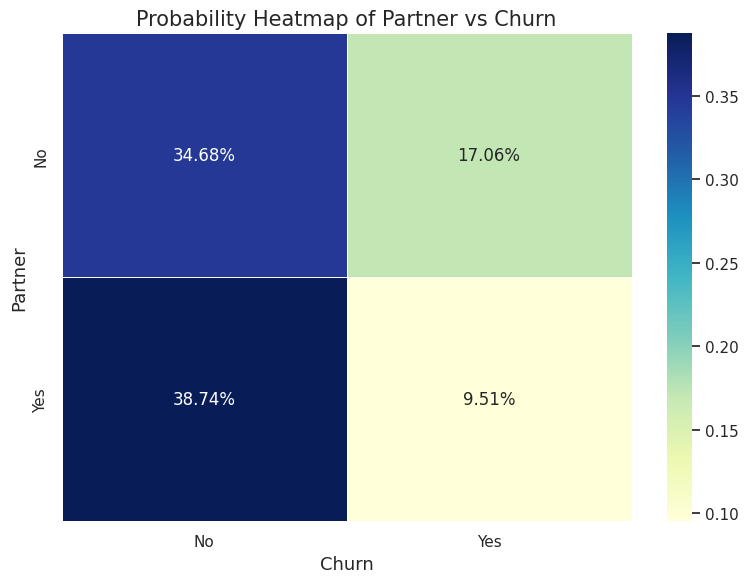

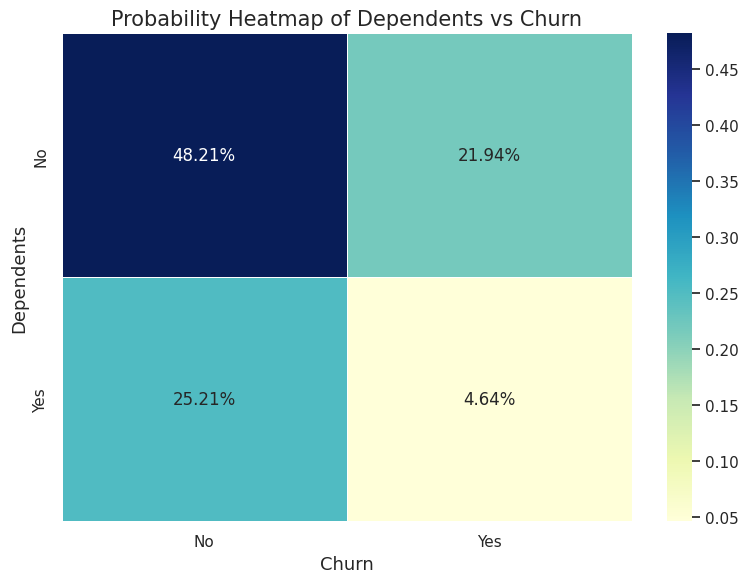

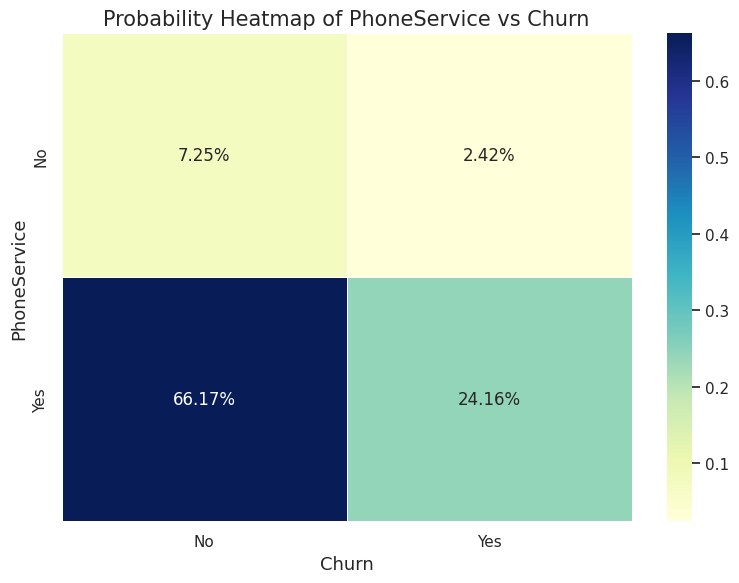

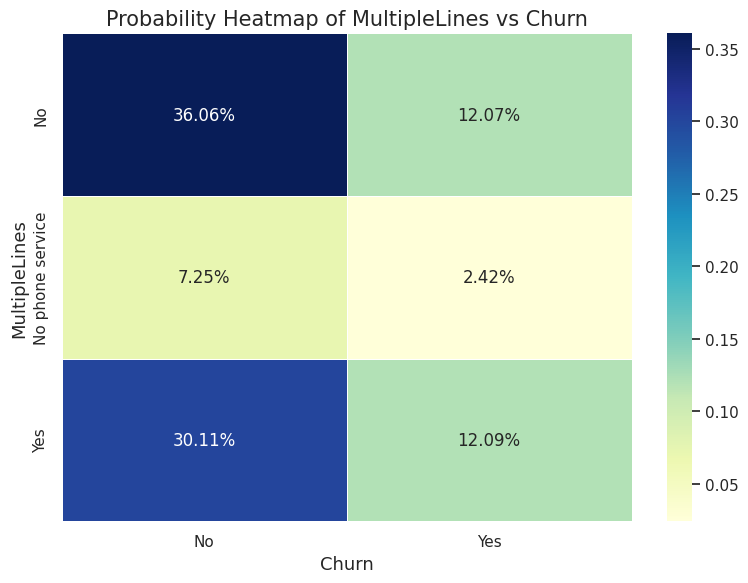

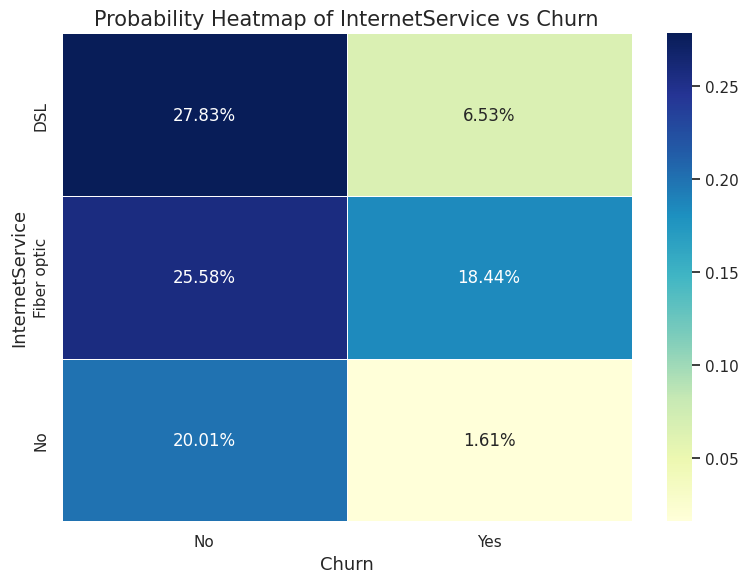

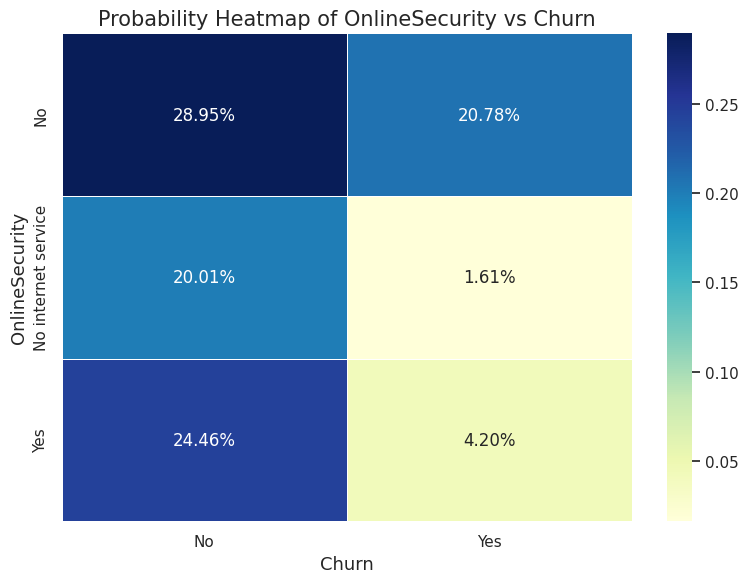

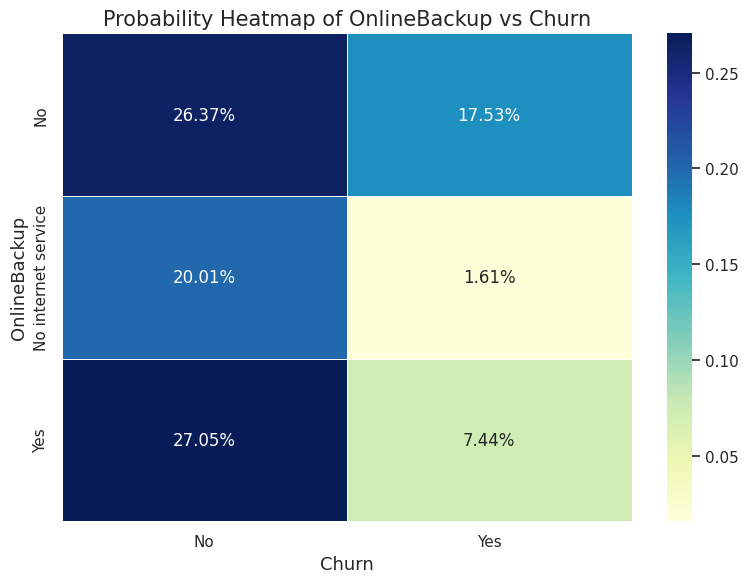

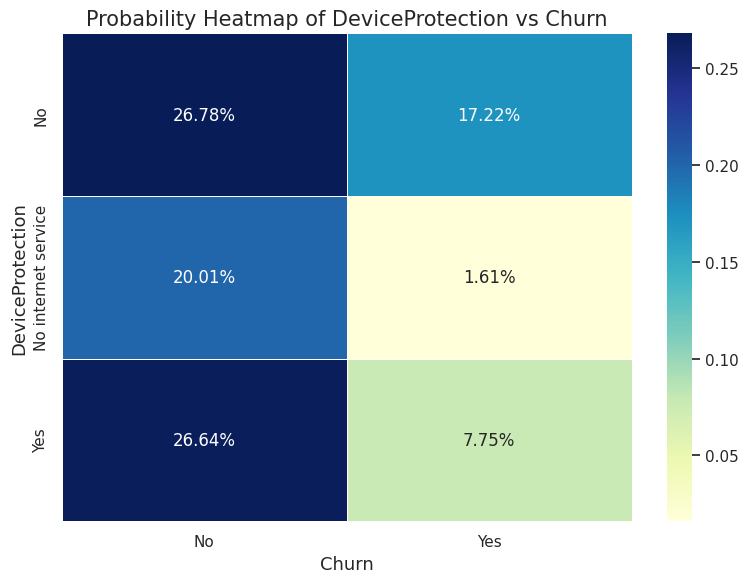

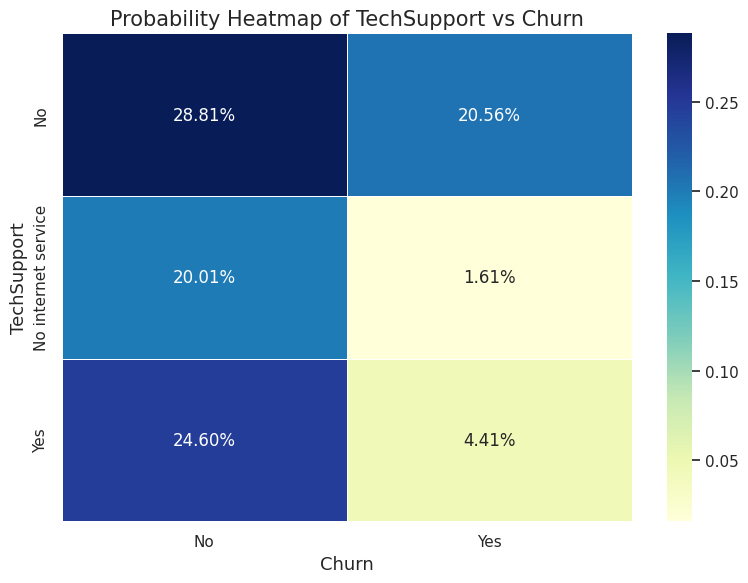

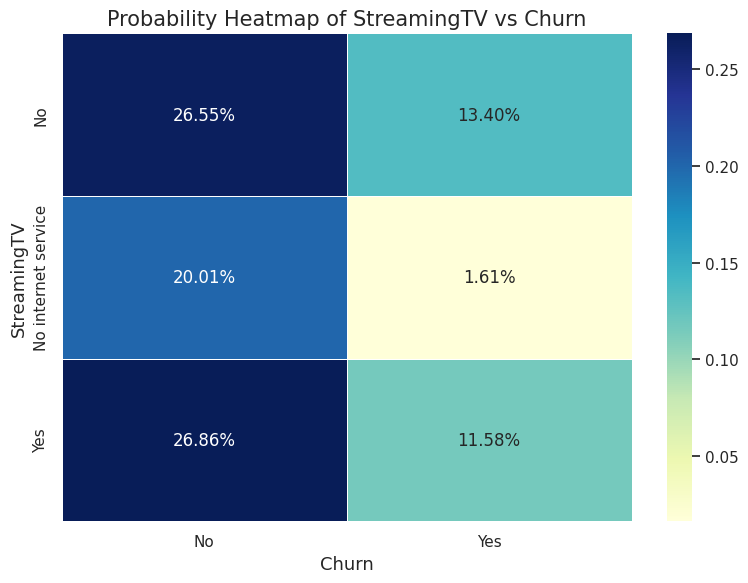

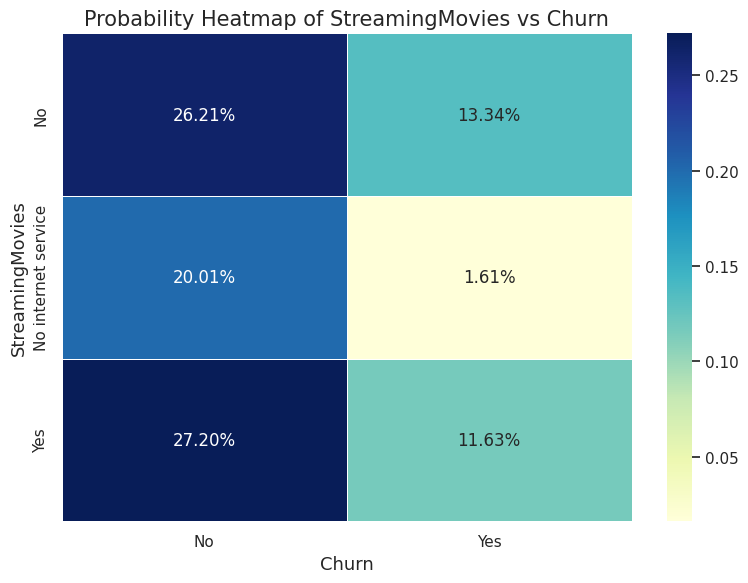

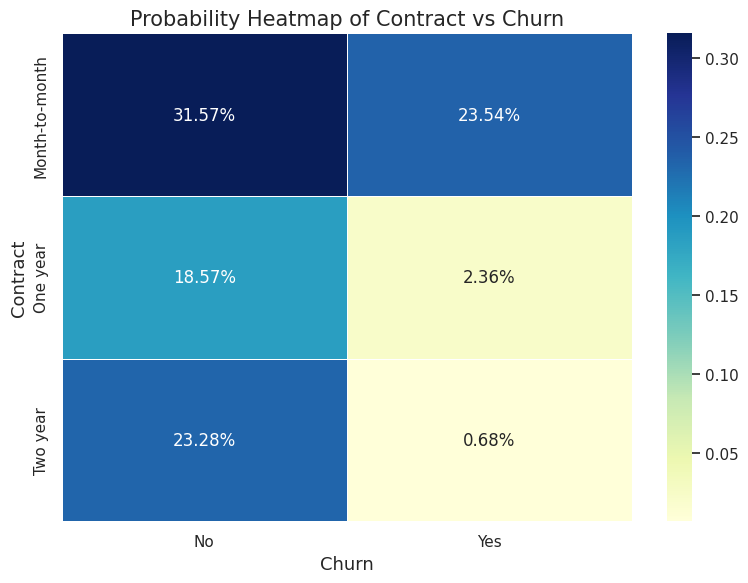

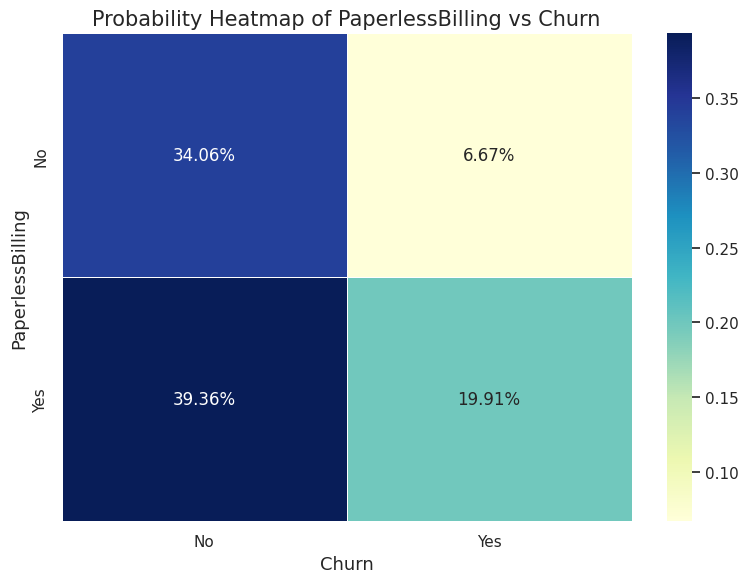

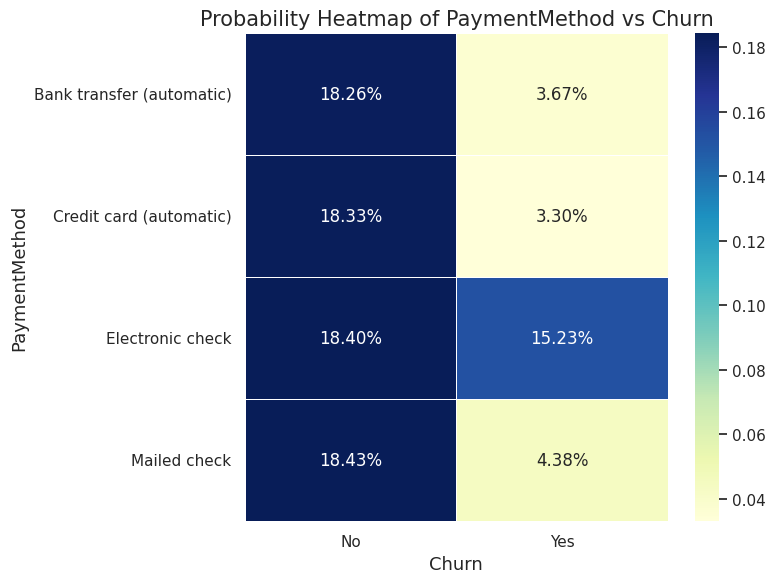

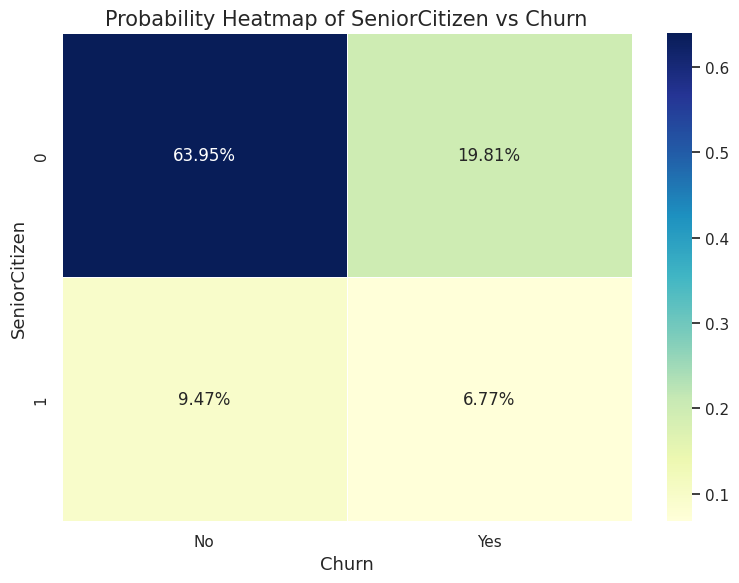

In [155]:
for col in categorical_cols:
    cross_tab = pd.crosstab(df[col], df['Churn'], normalize=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='.2%', linewidths=.5)
    plt.title(f'Probability Heatmap of {col} vs Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.show()

### Observations

*   **Gender** does not significantly influence churn probability, with similar distribution between male and female customers.
*   **Senior citizens** (SeniorCitizen = 1) show a higher probability of churning compared to non-senior citizens.
*   Customers without a **partner** or **dependents** generally exhibit a higher churn rate.
*   **PhoneService** presence or absence does not appear to be a strong indicator of churn.
*   Customers with **MultipleLines** have a slightly lower churn probability than those without.
*   Customers using **'Fiber optic' InternetService** show a considerably higher churn probability than those with 'DSL' or no internet service.
*   Customers who **do not subscribe** to additional services such as OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, or StreamingMovies generally have a higher churn probability.
*   Customers with **Month-to-month contracts** have a much higher churn probability compared to those with One-year or Two-year contracts.
*   Customers using **PaperlessBilling** have a higher churn rate.
*   **'Electronic check'** as a payment method shows a significantly higher churn probability compared to other methods.

### Insights

*   Key predictors of churn include having a month-to-month contract, using fiber optic internet, lacking online security/backup/tech support, not having a partner/dependents, utilizing electronic checks, and being a senior citizen.
*   These findings can be used to develop targeted retention strategies, such as offering incentives for longer-term contracts, promoting additional services, or analyzing the user experience for fiber optic customers and electronic check users.


# Analysis of Quantitative Features


In [120]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'SeniorCitizen' in numeric_cols:
    numeric_cols.remove('SeniorCitizen')

print("Numeric columns identified:")
print(numeric_cols)

Numeric columns identified:
['tenure', 'MonthlyCharges', 'TotalCharges']


## Distribution of Numeric Feature per Churn

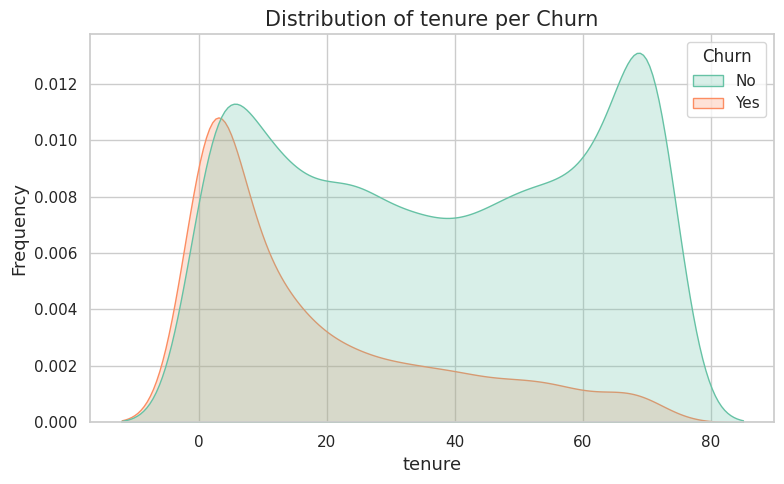

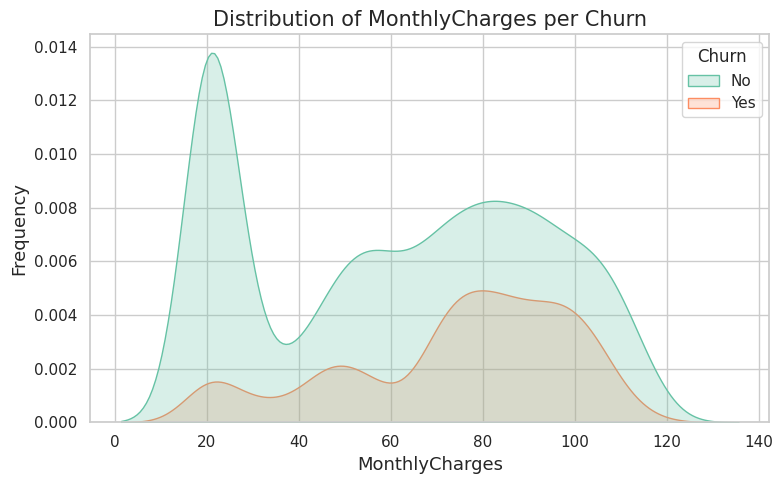

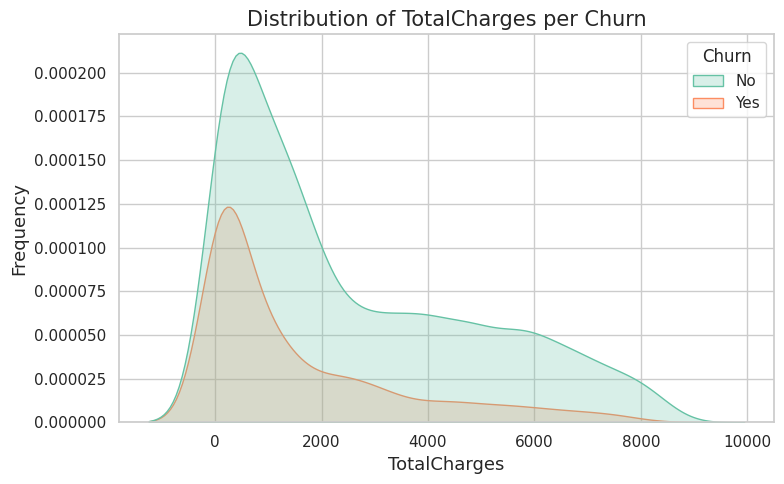

In [121]:
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data = df, x = df[col], fill = True, hue = df['Churn'])
    plt.title(f'Distribution of {col} per Churn')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

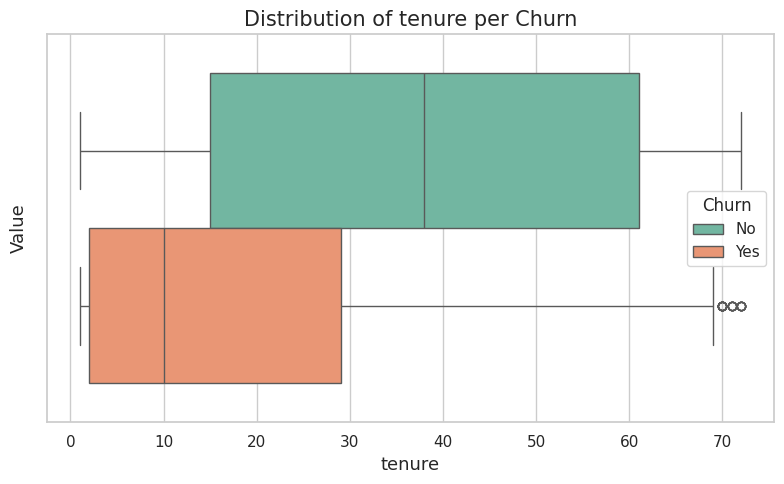

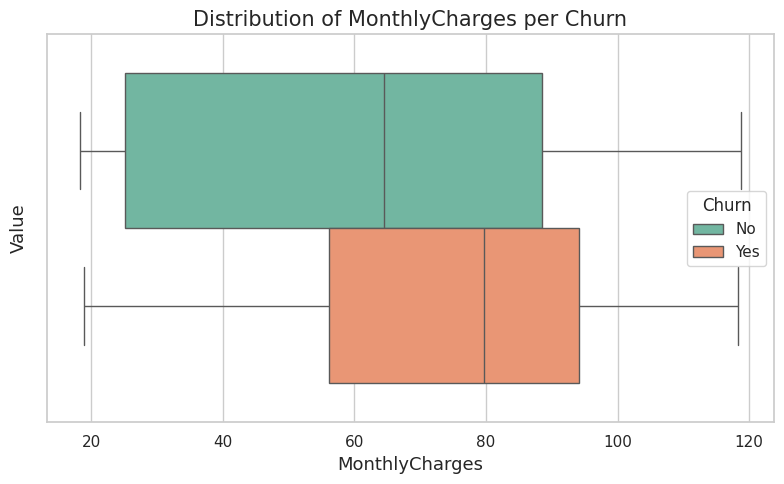

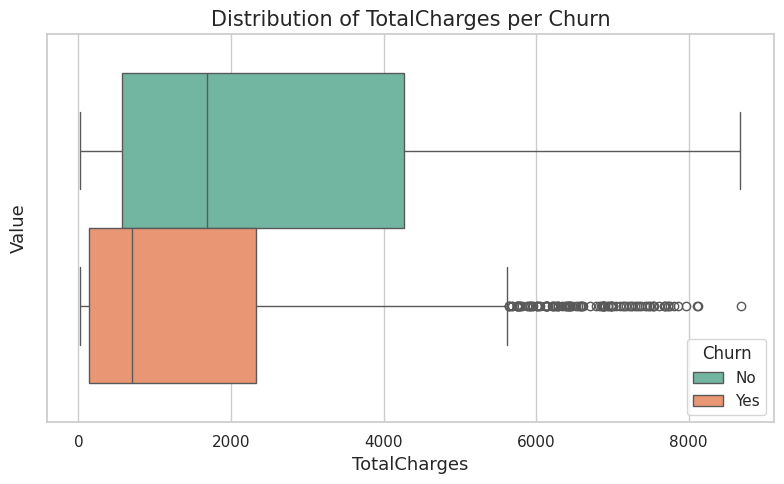

In [122]:
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data = df, x = df[col], hue = df['Churn'])
    plt.title(f'Distribution of {col} per Churn')
    plt.xlabel(col)
    plt.ylabel('Value')
    plt.show()

In [123]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [124]:
def get_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Bool mask for outliers
    mask = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Return only the outlier rows
    outliers_df = df.loc[mask, [column]]

    print(f"Column: {column}")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    print(f"Number of outliers: {mask.sum()}\n")

    return outliers_df

In [125]:
numeric_outliers = {}

for col in numeric_cols:
    numeric_outliers[col] = get_outliers_iqr(df, col) # apply function

Column: tenure
Lower bound: -60.0
Upper bound: 124.0
Number of outliers: 0

Column: MonthlyCharges
Lower bound: -45.824999999999996
Upper bound: 171.27499999999998
Number of outliers: 0

Column: TotalCharges
Lower bound: -4688.481250000001
Upper bound: 8884.66875
Number of outliers: 0



## Correlation Matrix

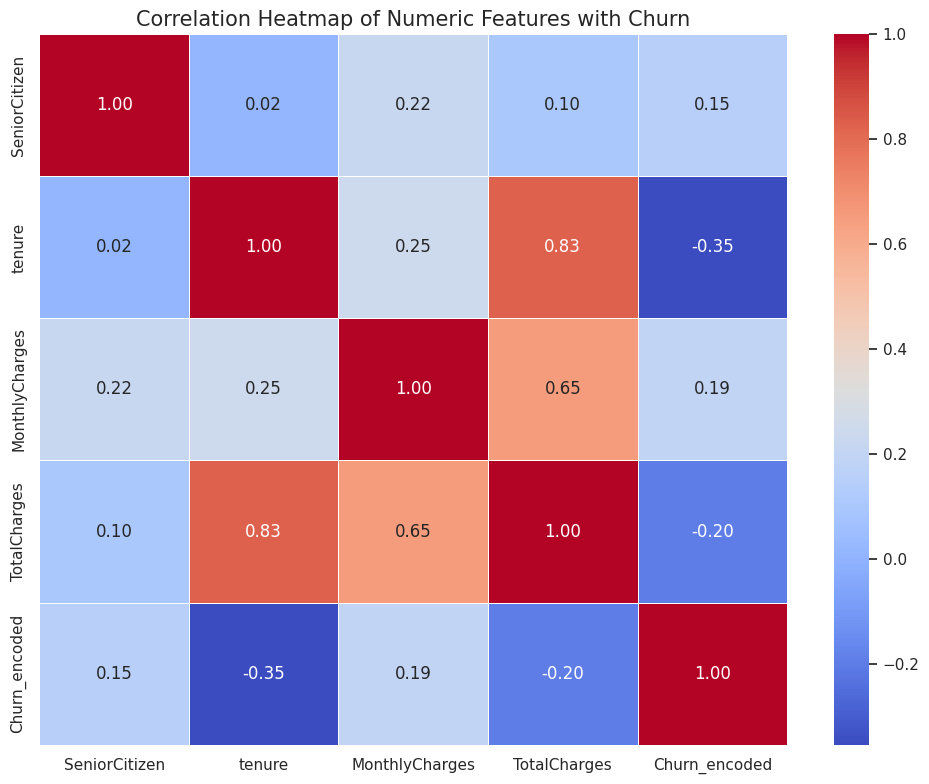

In [126]:
df['Churn_encoded'] = df['Churn'].map({'No': 0, 'Yes': 1})

numeric_df_with_churn = df.select_dtypes(include=['int64', 'float64'])
corr_matrix_with_churn = numeric_df_with_churn.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_with_churn, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features with Churn')
plt.show()

## Justification for Dropping 'TotalCharges'

Following the analysis of the correlation heatmap of numeric features, a very strong positive correlation of **0.83** was observed between `tenure` and `TotalCharges`. This indicates significant multicollinearity, where these two features convey largely redundant information, which makes sense since `TotalCharges` is a derivative of `tenure` and `MonthlyCharges`. To improve the interpretability and stability of our Logistic Regression model's coefficients without sacrificing predictive power, the `TotalCharges` feature is going to be dropped. This decision allows `tenure` to more accurately reflect its independent influence on churn, leading to a clearer and more robust model.

In [127]:
df = df.drop('TotalCharges', axis = 1)

In [128]:
if 'TotalCharges' in categorical_cols:
    categorical_cols.remove('TotalCharges')
if 'TotalCharges' in numeric_cols:
    numeric_cols.remove('TotalCharges')

print("Identified categorical columns:")
print(categorical_cols)
print("\nIdentified numeric columns:")
print(numeric_cols)

Identified categorical columns:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Identified numeric columns:
['tenure', 'MonthlyCharges']


In [130]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'Churn', 'Churn_encoded'],
      dtype='object')

# Feature Selection


## Chi_Squared for Categorical Features (Feature Importance)

Conduct a Chi-Squared statistical test for each categorical feature against the 'Churn' column.Quantitatively assess the independence of each categorical feature with the target, providing a statistical basis for selection.


In [131]:
print("Chi-Squared Test Results for Categorical Features vs Churn:")
for col in categorical_cols:
    # Contingency table
    contingency_table = pd.crosstab(df[col], df['Churn'])

    # Chi-Squared test
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    print(f"\nFeature: {col}")
    print(f"  Chi-Squared Statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")

    # Interpret the p-value (ar significance level of 0.05)
    alpha = 0.05
    if p_value < alpha:
        print(f"  Conclusion: There is a significant association between {col} and Churn (reject H0).")
    else:
        print(f"  Conclusion: There is no significant association between {col} and Churn (fail to reject H0).")

Chi-Squared Test Results for Categorical Features vs Churn:

Feature: gender
  Chi-Squared Statistic: 0.4755
  P-value: 0.4905
  Conclusion: There is no significant association between gender and Churn (fail to reject H0).

Feature: Partner
  Chi-Squared Statistic: 157.5032
  P-value: 0.0000
  Conclusion: There is a significant association between Partner and Churn (reject H0).

Feature: Dependents
  Chi-Squared Statistic: 186.3216
  P-value: 0.0000
  Conclusion: There is a significant association between Dependents and Churn (reject H0).

Feature: PhoneService
  Chi-Squared Statistic: 0.8737
  P-value: 0.3499
  Conclusion: There is no significant association between PhoneService and Churn (fail to reject H0).

Feature: MultipleLines
  Chi-Squared Statistic: 11.2715
  P-value: 0.0036
  Conclusion: There is a significant association between MultipleLines and Churn (reject H0).

Feature: InternetService
  Chi-Squared Statistic: 728.6956
  P-value: 0.0000
  Conclusion: There is a signific

## ANOVA_F_Test for Numerical Features

Conduct the ANOVA F-test (f_classif) for each numerical feature against 'Churn_encoded'. This identifies numerical features that show significant mean differences across churn groups, indicating their predictive power to the output.

In [132]:
print("ANOVA F-test Results for Numerical Features vs Churn:")
for col in numeric_cols:
    # ANOVA F-test
    f_statistic, p_value = f_classif(df[[col]], df['Churn_encoded'])

    print(f"\nFeature: {col}")
    print(f"  F-statistic: {f_statistic[0]:.4f}")
    print(f"  P-value: {p_value[0]:.4f}")

    # Interpret the p-value (at significance level of 0.05)
    alpha = 0.05
    if p_value[0] < alpha:
        print(f"  Conclusion: There is a significant association between {col} and Churn (reject Null Hypothesis).")
    else:
        print(f"  Conclusion: There is no significant association between {col} and Churn (fail to reject Null Hypothesis).")


ANOVA F-test Results for Numerical Features vs Churn:

Feature: tenure
  F-statistic: 1007.5094
  P-value: 0.0000
  Conclusion: There is a significant association between tenure and Churn (reject Null Hypothesis).

Feature: MonthlyCharges
  F-statistic: 271.5770
  P-value: 0.0000
  Conclusion: There is a significant association between MonthlyCharges and Churn (reject Null Hypothesis).


### Observations

All tested numerical features ('tenure', 'MonthlyCharges', and 'TotalCharges') showed a highly significant association with Churn, as indicated by their very low p-values (all 0.0000, which is much less than the significance level of 0.05). This quantitatively confirms that these features are strong predictors of customer churn and will be important for further modeling.

Based on both qualitative observations from probability heatmaps and quantitative statistical tests (Chi-Squared for categorical features, ANOVA F-test for numerical features), the following features are deemed most impactful for predicting customer churn and will be included in the machine learning model:

### Categorical Features:

*   **SeniorCitizen**: Qualitatively, senior citizens showed a higher churn probability. Quantitatively, the Chi-Squared test indicated a highly significant association (p < 0.0001) with churn.

*   **Partner**: Customers without a partner tended to churn more, as observed in the heatmaps. This was supported by a highly significant p-value (p < 0.0001) from the Chi-Squared test, indicating a strong association with churn.

*   **Dependents**: Similar to 'Partner', customers without dependents showed higher churn rates qualitatively, and the Chi-Squared test confirmed a highly significant association (p < 0.0001).

*   **MultipleLines**: While qualitatively a 'slight' difference was noted, the Chi-Squared test revealed a significant association (p = 0.0036), justifying its inclusion.

*   **InternetService**: "Fiber optic" internet users had a considerably higher churn probability, a clear visual pattern confirmed by a highly significant Chi-Squared p-value (p < 0.0001).

*   **OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies**: The absence of these additional services consistently correlated with higher churn in heatmaps. All these features demonstrated highly significant associations with churn based on their Chi-Squared test p-values (p < 0.0001 for all).

*   **Contract**: "Month-to-month" contracts were strongly associated with higher churn rates visually and had a very highly significant Chi-Squared p-value (p < 0.0001), making it a crucial predictor.

*   **PaperlessBilling**: Customers using paperless billing showed a higher churn rate in visualizations, and the Chi-Squared test confirmed a highly significant association (p < 0.0001).

*   **PaymentMethod**: "Electronic check" stood out as a payment method with a significantly higher churn probability in heatmaps. The Chi-Squared test yielded a highly significant p-value (p < 0.0001), validating its importance.

### Numerical Features:

*   **tenure**: Qualitative analysis showed differences in tenure distribution between churned and non-churned customers. The ANOVA F-test confirmed a highly significant association (p < 0.0001) between tenure and churn.

*   **MonthlyCharges**: Heatmaps and KDE plots suggested 'MonthlyCharges' had differing distributions for churned vs. non-churned customers. The ANOVA F-test supported this with a highly significant association (p < 0.0001).


### Excluded Features:

*   **customerID**: This is a unique identifier and has no predictive power for churn (Chi-Squared p = 0.4944).

*   **gender**: Both qualitative review of heatmaps and the Chi-Squared test (p = 0.4905) indicated no significant association with churn.

*   **PhoneService**: Visual inspection and the Chi-Squared test (p = 0.3499) showed no significant association with churn.

In [141]:
selected_features = [
    'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
    'tenure', 'MonthlyCharges'
]

X = df[selected_features].copy() # To avoid SettingWithCopyWarning
y = df['Churn_encoded'].copy()

# Identify categorical and numerical columns in X
categorical_features_for_model = X.select_dtypes(include='object').columns.tolist()
numerical_features_for_model = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Features identified in X:")
print(f"  Categorical: {categorical_features_for_model}")
print(f"  Numerical: {numerical_features_for_model}")

# One-hot encode the categorical features
X = pd.get_dummies(X, columns=categorical_features_for_model, drop_first=True)

print("\nShape of X (features DataFrame) after one-hot encoding:", X.shape)
print("First 5 rows of X after one-hot encoding:")
display(X.head())

Features identified in X:
  Categorical: ['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
  Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges']

Shape of X (features DataFrame) after one-hot encoding: (7032, 27)
First 5 rows of X after one-hot encoding:


,SeniorCitizen,tenure,MonthlyCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,True,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nDataset split into training and testing sets.")

X_train shape: (5625, 27)
X_test shape: (1407, 27)
y_train shape: (5625,)
y_test shape: (1407,)

Dataset split into training and testing sets.


In [135]:
print("Skewness for numerical columns before transformation (from original df):")
for col in ['tenure', 'MonthlyCharges']:
    skew_value = df[col].skew()
    print(f"  {col}: {skew_value:.4f}")

Skewness for numerical columns before transformation (from original df):
  tenure: 0.2377
  MonthlyCharges: -0.2221


In [147]:
scaler = StandardScaler()
pt = PowerTransformer(method='yeo-johnson')

# Exclude 'SeniorCitizen' from power transformation as it's a binary feature
numerical_features_to_transform = [col for col in numerical_features_for_model if col != 'SeniorCitizen']

# Scale and power transform the appropriate numerical columns in X
X_numerical_copy = X[numerical_features_to_transform].copy()
X_numerical_copy = scaler.fit_transform(X_numerical_copy)
X_numerical_copy = pt.fit_transform(X_numerical_copy)
X[numerical_features_to_transform] = X_numerical_copy

# Only apply StandardScaler to 'SeniorCitizen'
X[['SeniorCitizen']] = scaler.fit_transform(X[['SeniorCitizen']])

print("Standardization and Yeo-Johnson transformation applied to numerical columns in X (excluding SeniorCitizen for PowerTransformer).")
display(X.head())

Standardization and Yeo-Johnson transformation applied to numerical columns in X (excluding SeniorCitizen for PowerTransformer).


,SeniorCitizen,tenure,MonthlyCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.440327,-1.371436,-1.142665,True,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,-0.440327,0.168501,-0.348572,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,-0.440327,-1.319777,-0.445410,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,-0.440327,0.590250,-0.791141,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,-0.440327,-1.319777,0.108563,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


In [148]:
print("Skewness for numerical columns after Yeo-Johnson transformation (on X_train_new):")
for col in ['tenure', 'MonthlyCharges']:
    skew_value = X[col].skew()
    print(f"  {col}: {skew_value:.4f}")

Skewness for numerical columns after Yeo-Johnson transformation (on X_train_new):
  tenure: 0.0751
  MonthlyCharges: -0.0302


## Model Implementation

In [149]:
# Model initialization
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')

# Model training
log_reg_model.fit(X_train, y_train)

print("Logistic Regression model initialized and trained successfully.")

# Predictions on the test set
y_pred = log_reg_model.predict(X_test)
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the metrics
print("\nModel Performance Evaluation:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  ROC AUC: {roc_auc:.4f}")

Logistic Regression model initialized and trained successfully.

Model Performance Evaluation:
  Accuracy: 0.8010
  Precision: 0.6399
  Recall: 0.5749
  F1-Score: 0.6056
  ROC AUC: 0.8339


Classification Report (Initial Model):
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



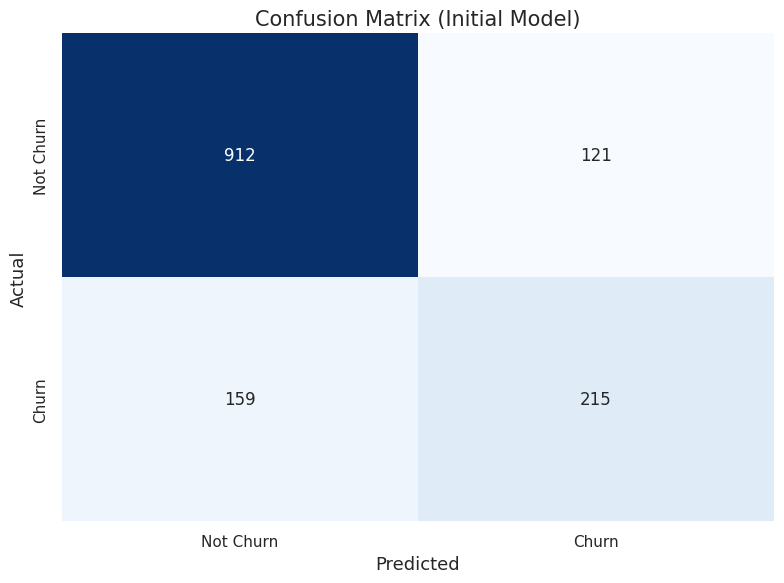

In [150]:
report = classification_report(y_test, y_pred)
print("Classification Report (Initial Model):\n", report)

# Confusion matrix using y_pred from the initial model
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Initial Model)')
plt.show()

## Observation
The initial model shows strong performance in correctly identifying non-churners, with 912 true negatives and an overall accuracy of 80%. However, the imbalance becomes clear in its churn detection ability: although the model correctly identifies 215 churners, it still misses 159 actual churn cases. This reflects a moderate recall for the churn class, meaning the model struggles to capture a significant portion of customers who actually leave. In churn prediction, missing churners is costly, so while the model is stable for general classification, it underperforms where it matters most—detecting customers at risk. This highlights the need for techniques like class rebalancing or alternative models to better capture minority-class churn behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


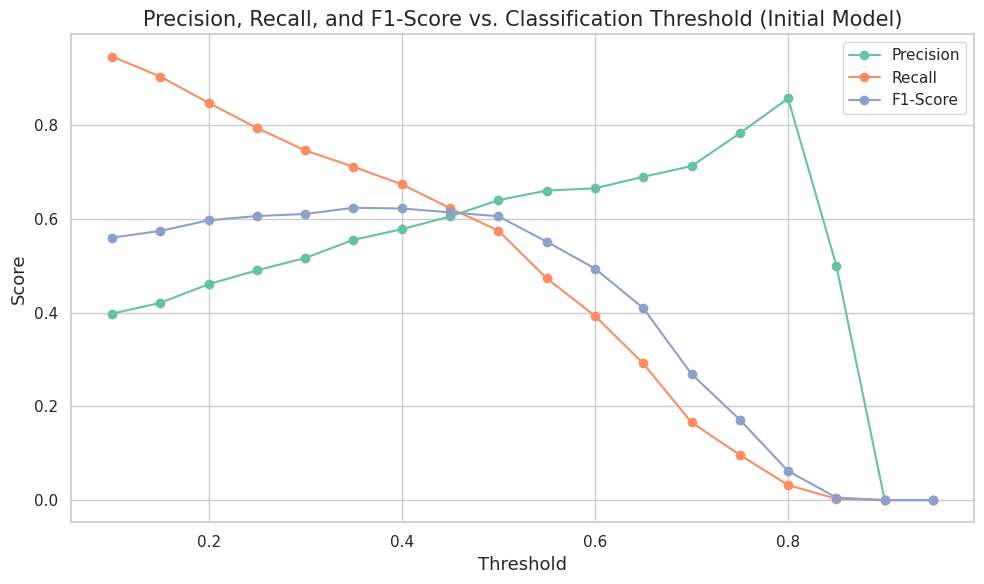


Model Performance with Optimal Threshold (0.3) for Initial Model:
  Accuracy: 0.7470
  Precision: 0.5167
  Recall: 0.7460
  F1-Score: 0.6105
  ROC AUC: 0.8339


In [152]:
# Probabilities for the positive class from the initial model
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Range of thresholds to test
thresholds = np.arange(0.1, 1.0, 0.05)

recalls = []
precisions = []
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    # Metrics
    recalls.append(recall_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Precision, Recall, and F1-score vs. Threshold plots
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
plt.title('Precision, Recall, and F1-Score vs. Classification Threshold (Initial Model)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()

# Based on the plot, we want a threshold that balances precision and recall.
# For example, if we prioritize recall, we might choose a lower threshold.
# Let's say we choose a threshold of 0.3 for illustration (from original analysis).
optimal_threshold = 0.3 # This value can be adjusted after visualizing the plot

y_pred_optimal_thresh = (y_pred_proba >= optimal_threshold).astype(int)

# Metrics recalculated with the optimal threshold
accuracy_opt = accuracy_score(y_test, y_pred_optimal_thresh)
precision_opt = precision_score(y_test, y_pred_optimal_thresh)
recall_opt = recall_score(y_test, y_pred_optimal_thresh)
f1_opt = f1_score(y_test, y_pred_optimal_thresh)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba)

print(f"\nModel Performance with Optimal Threshold ({optimal_threshold}) for Initial Model:")
print(f"  Accuracy: {accuracy_opt:.4f}")
print(f"  Precision: {precision_opt:.4f}")
print(f"  Recall: {recall_opt:.4f}")
print(f"  F1-Score: {f1_opt:.4f}")
print(f"  ROC AUC: {roc_auc_opt:.4f}")

### Observations
This threshold analysis shows how adjusting the classification threshold dramatically shifts the balance between precision and recall for the initial churn model. As the threshold decreases, the model becomes more aggressive in predicting churn, which boosts recall but lowers precision. Conversely, higher thresholds improve precision but miss many actual churners. The F1-score peaks around a threshold of 0.3, indicating the best balance between capturing churners and maintaining reasonable accuracy. At this optimal threshold, the model achieves a solid recall of 0.7460, meaning it successfully identifies most churn cases, although precision drops to 0.5167, reflecting more false positives. Overall, lowering the threshold is beneficial in churn scenarios where missing potential churners is more costly than incorrectly flagging a few loyal customers.

In [153]:
model_filename = 'logistic_regression_model.joblib'

# Trained model saved to the file
joblib.dump(log_reg_model, model_filename)

print(f"Logistic Regression model saved successfully to '{model_filename}'")

Logistic Regression model saved successfully to 'logistic_regression_model.joblib'
